In [1]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch

In [3]:
import numpy as np
import pandas as pd

In [5]:
data = pd.read_csv('./criteo_sample.txt')
sparse_features = ['C'+str(i) for i in range(1,27)]
dense_features = ['I'+str(i) for i in range(1,14)]
data[sparse_features] = data[sparse_features].fillna('-1')
data[dense_features] = data[dense_features].fillna(0)

In [6]:
target = ['label']
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [7]:
def sparseFeature(feat, feat_num, embed_dim=4):
    return {'feat':feat, 'feat_num':feat_num, 'embed_dim':embed_dim}
def denseFeature(feat):
    return {'feat':feat}
embed_dim = 8
feature_columns = [[denseFeature(feat) for feat in dense_features]] + [[sparseFeature(feat, len(data[feat].unique()), embed_dim=embed_dim) for feat in sparse_features]]

train_data, val_data = train_test_split(data, test_size=0.3, random_state=2020)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
print(feature_columns)
print(train_data.shape, val_data.shape)

[[{'feat': 'I1'}, {'feat': 'I2'}, {'feat': 'I3'}, {'feat': 'I4'}, {'feat': 'I5'}, {'feat': 'I6'}, {'feat': 'I7'}, {'feat': 'I8'}, {'feat': 'I9'}, {'feat': 'I10'}, {'feat': 'I11'}, {'feat': 'I12'}, {'feat': 'I13'}], [{'feat': 'C1', 'feat_num': 27, 'embed_dim': 8}, {'feat': 'C2', 'feat_num': 92, 'embed_dim': 8}, {'feat': 'C3', 'feat_num': 172, 'embed_dim': 8}, {'feat': 'C4', 'feat_num': 157, 'embed_dim': 8}, {'feat': 'C5', 'feat_num': 12, 'embed_dim': 8}, {'feat': 'C6', 'feat_num': 7, 'embed_dim': 8}, {'feat': 'C7', 'feat_num': 183, 'embed_dim': 8}, {'feat': 'C8', 'feat_num': 19, 'embed_dim': 8}, {'feat': 'C9', 'feat_num': 2, 'embed_dim': 8}, {'feat': 'C10', 'feat_num': 142, 'embed_dim': 8}, {'feat': 'C11', 'feat_num': 173, 'embed_dim': 8}, {'feat': 'C12', 'feat_num': 170, 'embed_dim': 8}, {'feat': 'C13', 'feat_num': 166, 'embed_dim': 8}, {'feat': 'C14', 'feat_num': 14, 'embed_dim': 8}, {'feat': 'C15', 'feat_num': 170, 'embed_dim': 8}, {'feat': 'C16', 'feat_num': 168, 'embed_dim': 8}, {'

In [8]:
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [57]:
trn_x = train_data.drop('label', axis=1).values
trn_y = train_data['label'].values
val_x = val_data.drop('label', axis=1).values
val_y = val_data['label'].values
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

for b in iter(dl_train):
    print(b[0].shape, b[1])
    print(b[1].shape)
    break

torch.Size([32, 39]) tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
torch.Size([32])


In [10]:
class CIN(nn.Module):
    def __init__(self, field_size, layer_size=(128,128), activation='relu'):
        super(CIN, self).__init__()
        self.layer_size = layer_size
        self.field_nums = [field_size]
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        self.conv1ds = nn.ModuleList()
        for i, size in enumerate(self.layer_size):
            self.conv1ds.append(nn.Conv1d(self.field_nums[-1]*self.field_nums[0], size, 1))
            self.field_nums.append(size)
    def forward(self, inputs):
        if len(inputs.shape) != 3:
            raise  ValueError('Unexpected inputs dimensions %d,expect to be 3 dimensions' % (len(inputs.shape)))
        batch_size = inputs.shape[0]
        dim = inputs.shape[-1]
        hidden_nn_layers = [inputs]
        final_result = []
        
        for i, size in enumerate(self.layer_size):
            #x^(k-1)*x^0
            x = torch.einsum('bhd,bmd->bhmd', hidden_nn_layers[-1], hidden_nn_layers[0])
            #x.shape = (batch_size, hi*m, dim)
            x = x.reshape(batch_size, hidden_nn_layers[-1].shape[1] * hidden_nn_layers[0].shape[1], dim)
            x = self.conv1ds[i](x)
            if self.activation is None:
                curr_out = x
            else:
                curr_out = self.activation(x)
            direct_connect = curr_out
            next_hidden = curr_out
            
            final_result.append(direct_connect)
            hidden_nn_layers.append(next_hidden)
        
        result = torch.cat(final_result, dim=1)
        result = torch.sum(result, -1)
        return result

In [15]:
class Dnn(nn.Module):
    def __init__(self, hidden_units):
        super(Dnn, self).__init__()
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
    def forward(self, x):
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
        return x

In [59]:
class xDeepFM(nn.Module):
    def __init__(self, feature_columns, linear_output_size, dnn_hidden_units=[256, 256], cin_layer_size=[256, 128], cin_activation='relu'):
        super(xDeepFM, self).__init__()
        self.dnn_hidden_units = dnn_hidden_units
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        self.linear_output_size = linear_output_size
        
        #embedding
        self.embed_layers = nn.ModuleDict({
            'embed_'+str(i):nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim']) for i, feat in enumerate(self.sparse_feature_cols)
        })
        feature_len = len(self.dense_feature_cols) + len(self.sparse_feature_cols) * self.sparse_feature_cols[0]['embed_dim']
        dnn_hidden_units.insert(0, len(self.dense_feature_cols) + len(self.sparse_feature_cols) * self.sparse_feature_cols[0]['embed_dim'])
        self.dnn_network = Dnn(dnn_hidden_units)
        self.final_linear = nn.Linear(dnn_hidden_units[-1], 1)
        
        
        self.cin_layer_size = cin_layer_size
        field_num = len(self.sparse_feature_cols)
        self.featuremap_num = sum(cin_layer_size)
        self.cin = CIN(field_num, cin_layer_size, cin_activation)
        self.cin_linear = nn.Linear(self.featuremap_num, 1)
        
        self.linear_model = nn.Linear(feature_len, linear_output_size)
        
    def forward(self, x):
        batch_size = x.shape[0]
        dense_input, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
#         print('dense_input:', dense_input.shape)
#         print('sparse_inputs:', sparse_inputs.shape)
        sparse_inputs = sparse_inputs.long()
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:,i]) for i in range(sparse_inputs.shape[1])]
#         print('spar')
#                 sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:,i]) for i in range(sparse_inputs.shape[1])]
        dnn_sparse_embeds = torch.cat(sparse_embeds, -1)
        
        dnn_input = torch.cat([dnn_sparse_embeds, dense_input], -1)
        
        #Linear 部分
        linear_out = self.linear_model(dnn_input)
        
        #deep部分
        deep_out = self.dnn_network(dnn_input)
        deep_out = self.final_linear(deep_out)
        
        #cin部分
#         print('sparse_embeds', len(sparse_embeds), sparse_embeds[0].shape)
        cin_input = torch.cat(sparse_embeds, 1)
        cin_input = cin_input.reshape(batch_size, -1, 8)
#         print('cin_input', cin_input.shape)
        cin_output = self.cin(cin_input)
        cin_output = self.cin_linear(cin_output)
        
        final_output = linear_out + deep_out + cin_output
        final_output = torch.sigmoid(final_output)
        return final_output

In [66]:
linear_output_size = 1
dnn_hidden_units = [128, 64]
cin_layer_size = [256, 128]
model = xDeepFM(feature_columns=feature_columns, linear_output_size=linear_output_size, dnn_hidden_units=dnn_hidden_units, cin_layer_size=cin_layer_size)
model

xDeepFM(
  (embed_layers): ModuleDict(
    (embed_0): Embedding(27, 8)
    (embed_1): Embedding(92, 8)
    (embed_2): Embedding(172, 8)
    (embed_3): Embedding(157, 8)
    (embed_4): Embedding(12, 8)
    (embed_5): Embedding(7, 8)
    (embed_6): Embedding(183, 8)
    (embed_7): Embedding(19, 8)
    (embed_8): Embedding(2, 8)
    (embed_9): Embedding(142, 8)
    (embed_10): Embedding(173, 8)
    (embed_11): Embedding(170, 8)
    (embed_12): Embedding(166, 8)
    (embed_13): Embedding(14, 8)
    (embed_14): Embedding(170, 8)
    (embed_15): Embedding(168, 8)
    (embed_16): Embedding(9, 8)
    (embed_17): Embedding(127, 8)
    (embed_18): Embedding(44, 8)
    (embed_19): Embedding(4, 8)
    (embed_20): Embedding(169, 8)
    (embed_21): Embedding(6, 8)
    (embed_22): Embedding(10, 8)
    (embed_23): Embedding(125, 8)
    (embed_24): Embedding(20, 8)
    (embed_25): Embedding(90, 8)
  )
  (dnn_network): Dnn(
    (dnn_network): ModuleList(
      (0): Linear(in_features=221, out_features=1

In [67]:
#测试一下模型
for fea, label in iter(dl_train):
    out = model(fea)
    print(out)
    break

tensor([[0.7632],
        [0.8361],
        [0.7483],
        [0.8745],
        [0.8159],
        [0.9355],
        [0.8084],
        [0.8073],
        [0.8993],
        [0.8410],
        [0.8483],
        [0.7955],
        [0.7476],
        [0.8045],
        [0.8451],
        [0.8379],
        [0.8368],
        [0.8029],
        [0.8928],
        [0.7430],
        [0.6447],
        [0.7814],
        [0.6495],
        [0.7623],
        [0.6720],
        [0.7676],
        [0.8685],
        [0.6830],
        [0.7281],
        [0.7165],
        [0.7984],
        [0.7805]], grad_fn=<SigmoidBackward0>)


In [68]:
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'
import datetime

In [69]:
epochs = 10
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model(features).reshape(-1)
#         print('predictions', predictions.shape, labels.shape)
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features).reshape(-1)
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2022-09-27 16:24:44

EPOCH=1, loss=1.179, auc = 0.470, val_loss=0.728, val_auc = 0.485

================================================================================2022-09-27 16:24:44

EPOCH=2, loss=0.301, auc = 0.977, val_loss=0.709, val_auc = 0.574

================================================================================2022-09-27 16:24:44

EPOCH=3, loss=0.042, auc = 1.000, val_loss=0.960, val_auc = 0.582

================================================================================2022-09-27 16:24:45

EPOCH=4, loss=0.040, auc = 1.000, val_loss=1.099, val_auc = 0.585

================================================================================2022-09-27 16:24:45

EPOCH=5, loss=0.014, auc = 1.000, val_loss=1.087, val_auc = 0.529

================================================================================2022-09-27 16:24:45

EPOCH=6, loss=0.005, auc = 1.000, val_loss=1.059, v

d:\anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\anaconda\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


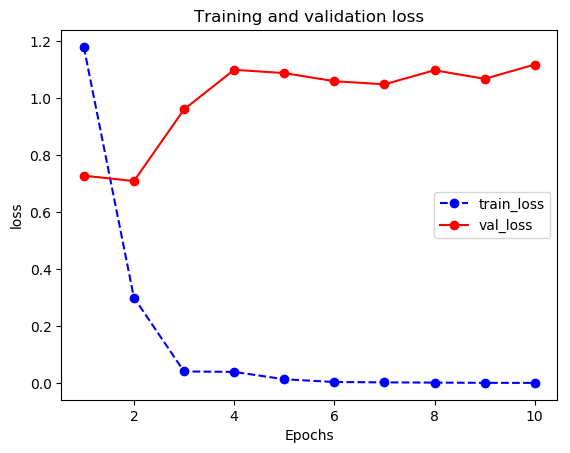

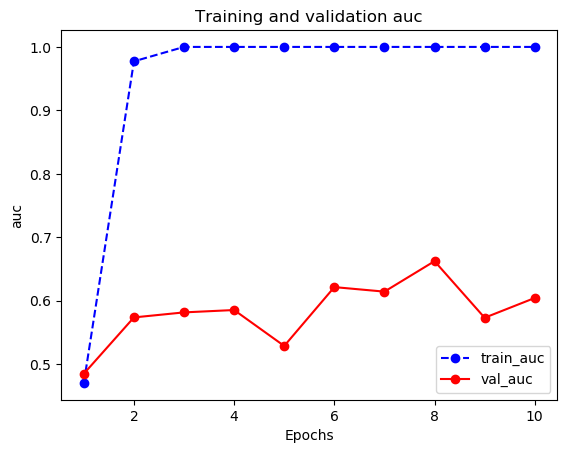

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化,看loss 可以看到过拟合
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")